#Initial Set-Up

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, random, torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [14]:
data_src = 'solar_data_combined_cleaned.csv'
data_df = pd.read_csv(data_src)

In [15]:
data_df

,datetime,local_datetime,Year,Month,Day,Hour,Minute,Temperature,Alpha,AOD,...,Ozone,Relative Humidity,Solar Zenith Angle,SSA,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Kcs
0,2018-01-01 16:30:00,2018-01-01 09:30:00,2018.0,1.0,1.0,16.0,30.0,-1.2,1.20,0.021,...,0.347,34.07,72.17,0.91,0.13,830.0,0.4,254.0,1.1,0.451
1,2018-01-01 16:40:00,2018-01-01 09:40:00,2018.0,1.0,1.0,16.0,40.0,-0.8,1.20,0.021,...,0.347,34.81,71.05,0.91,0.13,829.0,0.4,257.0,0.9,0.561
2,2018-01-01 16:50:00,2018-01-01 09:50:00,2018.0,1.0,1.0,16.0,50.0,-0.3,1.20,0.021,...,0.346,33.56,69.98,0.91,0.13,829.0,0.4,259.0,0.7,0.568
3,2018-01-01 17:00:00,2018-01-01 10:00:00,2018.0,1.0,1.0,17.0,0.0,0.1,1.20,0.021,...,0.346,32.60,68.98,0.91,0.13,829.0,0.4,262.0,0.5,0.596
4,2018-01-01 17:10:00,2018-01-01 10:10:00,2018.0,1.0,1.0,17.0,10.0,0.5,1.20,0.021,...,0.345,31.68,68.04,0.91,0.13,829.0,0.4,219.0,0.5,0.607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142466,2023-12-31 22:00:00,2023-12-31 15:00:00,2023.0,12.0,31.0,22.0,0.0,3.1,1.15,0.029,...,0.326,57.39,75.10,0.86,0.12,827.0,0.7,71.0,0.6,0.822
142467,2023-12-31 22:10:00,2023-12-31 15:10:00,2023.0,12.0,31.0,22.0,10.0,2.8,1.15,0.029,...,0.326,58.62,76.39,0.86,0.12,827.0,0.7,74.0,0.6,0.824
142468,2023-12-31 22:20:00,2023-12-31 15:20:00,2023.0,12.0,31.0,22.0,20.0,2.5,1.15,0.029,...,0.327,59.88,77.74,0.87,0.12,827.0,0.7,77.0,0.5,0.781
142469,2023-12-31 22:30:00,2023-12-31 15:30:00,2023.0,12.0,31.0,22.0,30.0,2.2,1.15,0.029,...,0.327,61.17,79.12,0.87,0.12,827.0,0.7,80.0,0.5,0.735


In [16]:
from copy import deepcopy as dc

data = dc(data_df)
data['local_datetime'] = pd.to_datetime(data_df['local_datetime'], errors='coerce')
data.dropna(subset=['local_datetime'], inplace=True)
data.set_index('local_datetime', inplace = True)
data.drop('datetime', axis = 1, inplace = True)
data['Target'] = data['GHI'].shift(-12)
data.dropna(inplace = True)

In [17]:
data

,Year,Month,Day,Hour,Minute,Temperature,Alpha,AOD,Asymmetry,Clearsky DHI,...,Relative Humidity,Solar Zenith Angle,SSA,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Kcs,Target
local_datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 09:30:00,2018.0,1.0,1.0,16.0,30.0,-1.2,1.20,0.021,0.62,46.0,...,34.07,72.17,0.91,0.13,830.0,0.4,254.0,1.1,0.451,378.0
2018-01-01 09:40:00,2018.0,1.0,1.0,16.0,40.0,-0.8,1.20,0.021,0.62,47.0,...,34.81,71.05,0.91,0.13,829.0,0.4,257.0,0.9,0.561,499.0
2018-01-01 09:50:00,2018.0,1.0,1.0,16.0,50.0,-0.3,1.20,0.021,0.62,48.0,...,33.56,69.98,0.91,0.13,829.0,0.4,259.0,0.7,0.568,502.0
2018-01-01 10:00:00,2018.0,1.0,1.0,17.0,0.0,0.1,1.20,0.021,0.62,49.0,...,32.60,68.98,0.91,0.13,829.0,0.4,262.0,0.5,0.596,504.0
2018-01-01 10:10:00,2018.0,1.0,1.0,17.0,10.0,0.5,1.20,0.021,0.62,50.0,...,31.68,68.04,0.91,0.13,829.0,0.4,219.0,0.5,0.607,504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 13:00:00,2023.0,12.0,31.0,20.0,0.0,5.5,1.19,0.028,0.62,56.0,...,40.11,64.18,0.86,0.12,826.0,0.6,29.0,1.5,0.849,203.0
2023-12-31 13:10:00,2023.0,12.0,31.0,20.0,10.0,5.4,1.19,0.028,0.62,55.0,...,40.38,64.70,0.86,0.12,826.0,0.6,32.0,1.4,0.796,183.0
2023-12-31 13:20:00,2023.0,12.0,31.0,20.0,20.0,5.3,1.19,0.028,0.62,55.0,...,40.66,65.30,0.86,0.12,826.0,0.6,34.0,1.4,0.781,153.0


In [18]:
# Calculate autocorrelation manually
max_lag = 50  # Number of lags to evaluate
autocorr_values = [data['Target'].autocorr(lag=i) for i in range(1, max_lag + 1)]

# Display results
for lag, corr in enumerate(autocorr_values, 1):
    print(f'Lag {lag}: {corr:.3f}')

Lag 1: 0.964
Lag 2: 0.933
Lag 3: 0.901
Lag 4: 0.866
Lag 5: 0.827
Lag 6: 0.785
Lag 7: 0.740
Lag 8: 0.692
Lag 9: 0.642
Lag 10: 0.589
Lag 11: 0.535
Lag 12: 0.480
Lag 13: 0.423
Lag 14: 0.365
Lag 15: 0.307
Lag 16: 0.249
Lag 17: 0.192
Lag 18: 0.135
Lag 19: 0.080
Lag 20: 0.027
Lag 21: -0.024
Lag 22: -0.073
Lag 23: -0.118
Lag 24: -0.161
Lag 25: -0.201
Lag 26: -0.236
Lag 27: -0.269
Lag 28: -0.296
Lag 29: -0.320
Lag 30: -0.339
Lag 31: -0.354
Lag 32: -0.364
Lag 33: -0.370
Lag 34: -0.372
Lag 35: -0.369
Lag 36: -0.362
Lag 37: -0.351
Lag 38: -0.336
Lag 39: -0.317
Lag 40: -0.294
Lag 41: -0.269
Lag 42: -0.240
Lag 43: -0.208
Lag 44: -0.175
Lag 45: -0.139
Lag 46: -0.101
Lag 47: -0.062
Lag 48: -0.022
Lag 49: 0.019
Lag 50: 0.060


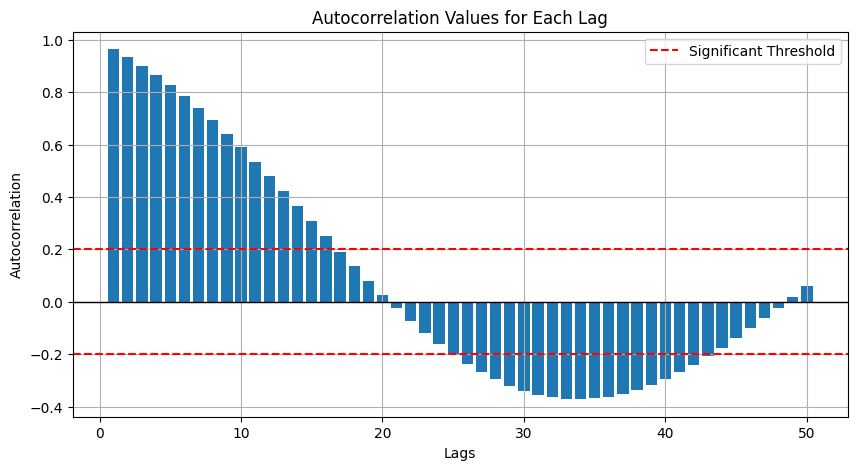

In [19]:
plt.figure(figsize=(10, 5))
plt.bar(range(1, max_lag + 1), autocorr_values)
plt.axhline(y=0, color='black', linewidth=1)
plt.axhline(y=0.2, color='red', linestyle='--', label='Significant Threshold')
plt.axhline(y=-0.2, color='red', linestyle='--')
plt.title('Autocorrelation Values for Each Lag')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.legend()
plt.grid(True)
plt.show()

#LSTM Setup

In [20]:
import torch

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout = 0.0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout = dropout, bidirectional = True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
      batch_size = x.size(0)
      h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(device)
      c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(device)
      lstm_out, (h_n, _) = self.lstm(x, (h0, c0))
      return self.fc(lstm_out[:, -1, :])

#Bidirectional LSTM Built

In [22]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout = 0.0):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout = dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
      batch_size = x.size(0)
      h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
      c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
      lstm_out, (h_n, _) = self.lstm(x, (h0, c0))
      return self.fc(lstm_out[:, -1, :])

#Linear LSTM Built

In [23]:
def initialize_model(input_size, neurons, num_layers = 1, learning_rate = 1e-3):
  model = LSTMModel(input_size=input_size, hidden_size=neurons, num_layers=num_layers).to(device)
  criterion = nn.SmoothL1Loss(beta=1.0)
  optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, min_lr = 1e-5, threshold = 0.001)
  return model, criterion, optimizer, scheduler

In [24]:
def train_epoch(model, optimizer, criterion, train_loader):
  model.train(True)
  train_loss = 0

  for batch_idx, (batch_X, batch_Y) in enumerate(train_loader):
      batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)

      optimizer.zero_grad()
      outputs = model(batch_X)
      loss = criterion(outputs, batch_Y)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() #Use Detach Function

  avg_train_loss = train_loss / len(train_loader)
  return avg_train_loss

In [25]:
def val_epoch(model, criterion, scheduler, val_loader):
  model.eval()
  val_loss = 0
  with torch.no_grad():
      for batch_idx, (batch_X, batch_Y) in enumerate(val_loader):
          batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
          outputs = model(batch_X)
          loss = criterion(outputs, batch_Y)
          val_loss += loss.item()

  avg_val_loss = val_loss / len(val_loader)
  scheduler.step(avg_val_loss)
  return avg_val_loss

In [26]:
def compute_error(model, X_test_tensor, Y_test_tensor, Y_scaler):
    model.eval()
    with torch.no_grad():
      outputs = model(X_test_tensor).cpu().numpy().flatten()
      outputs = Y_scaler.inverse_transform(outputs.reshape(-1, 1)).flatten()

      actual = Y_test_tensor.cpu().numpy().flatten()
      actual = Y_scaler.inverse_transform(actual.reshape(-1, 1)).flatten()

    rmse = np.sqrt(mean_squared_error(actual, outputs))
    nrmse_mean = rmse / np.mean(actual)
    mae = mean_absolute_error(actual, outputs)
    return rmse, nrmse_mean, mae

In [27]:
class EarlyStopping:
    def __init__(self, patience, optimizer, min_delta = 1e-4):
        self.patience = patience
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.min_delta = min_delta
        self.min_lr = 1e-5
        self.optimizer = optimizer
        self.best_model_state = None

    def check(self, model, avg_val_loss):
        if (self.best_val_loss - avg_val_loss) > self.min_delta:
            self.best_val_loss = avg_val_loss
            self.patience_counter = 0
            self.best_model_state = model.state_dict()  # Save Ideal Model State
        else:
            self.patience_counter += 1
            current_lr = self.optimizer.param_groups[0]['lr']
            if self.patience_counter >= self.patience and current_lr <= self.min_lr:
                print("\n🛑 Early stopping triggered. Restoring best model...")
                model.load_state_dict(self.best_model_state)  # Restore best model
                return True  # Signal to Stop Training
        return False  # Continue Training

In [28]:
def run_model(model, epochs, scheduler, optimizer, criterion, train_loader, val_loader, X_test_tensor, Y_test_tensor, Y_scaler):
  torch.cuda.empty_cache()
  early_stopping = EarlyStopping(patience=10, optimizer = optimizer, min_delta = 1e-5)
  print("Training Model", model)

  lowest_rmse, lowest_nrmse = float('inf'), float('inf')

  for epoch in range(epochs):
    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        print(f"\n🔄 Epoch [{epoch+1}/{epochs}] - Training...")

    prev_lr = optimizer.param_groups[0]['lr']

    avg_train_loss = train_epoch(model, optimizer, criterion, train_loader)
    avg_val_loss = val_epoch(model, criterion, scheduler, val_loader)
    rmse, nrmse, mae = compute_error(model, X_test_tensor, Y_test_tensor, Y_scaler)

    current_lr = optimizer.param_groups[0]['lr']
    if current_lr != prev_lr:
        print(f"📉 Learning Rate Reduced at Epoch {epoch + 1}: New LR = {current_lr:.6f}")
        prev_lr = current_lr

    if rmse < lowest_rmse:
      lowest_rmse = rmse
      lowest_nrmse = nrmse

    stop = early_stopping.check(model, avg_val_loss)
    if stop: break

    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
      print(f"📉 Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}, RMSE: {rmse:.4f}, nRMSE: {nrmse:.4f}")

  performance = {
        'model_config': model,
        'rmse': lowest_rmse,
        'nrmse': lowest_nrmse,
        'mae': mae
          }
  return performance

#Baseline Model (Entire Feature Set)

In [29]:
def create_3D_sequences(data, timesteps):
    X = []
    Y = []
    data_np = data.drop('Target', axis=1).to_numpy()  # Exclude 'Target' from X
    target_np = data['Target'].to_numpy()             # Isolate 'Target'

    for i in range(len(data_np) - timesteps):
        X.append(data_np[i:i + timesteps])
        Y.append(target_np[i + timesteps])

    return np.array(X), np.array(Y)

In [30]:
timesteps = 30
X, Y = create_3D_sequences(data, timesteps)

In [31]:
def data_split_scale(X, Y):
  train = int(0.8 * len(X))  # 80% Train
  test = len(X) - train #20% test

  X_train, Y_train = X[:train], Y[:train]
  X_test, Y_test = X[train:], Y[train:]

  X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  X_scaler = MinMaxScaler(feature_range=(-1,1))
  Y_scaler = MinMaxScaler(feature_range=(-1,1))

  #Flattening Dataset For Scaling

  X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
  X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

  X_train_scaled = X_scaler.fit_transform(X_train_reshaped)
  X_test_scaled = X_scaler.transform(X_test_reshaped)

  #Reshaping Back Into 3D Dataset

  X_train_scaled = X_train_scaled.reshape(X_train.shape)
  X_test_scaled = X_test_scaled.reshape(X_test.shape)

  Y_train_scaled = Y_scaler.fit_transform(Y_train.reshape(-1,1))
  Y_test_scaled = Y_scaler.transform(Y_test.reshape(-1,1))

  return X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, X_scaler, Y_scaler

X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, X_scaler, Y_scaler = data_split_scale(X, Y)

In [32]:
X_train_scaled.shape, X_test_scaled.shape, Y_train_scaled.shape, Y_test_scaled.shape

((113942, 30, 26), (28486, 30, 26), (113942, 1), (28486, 1))

In [33]:
class TimeSeriesData(Dataset):
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.Y[i]

In [34]:
def data_handler(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, batch_size = 256):
  X_train_tensor = torch.tensor(X_train_scaled, dtype = torch.float32).to(device)
  Y_train_tensor = torch.tensor(Y_train_scaled, dtype = torch.float32).to(device)
  X_test_tensor = torch.tensor(X_test_scaled, dtype = torch.float32).to(device)
  Y_test_tensor = torch.tensor(Y_test_scaled, dtype = torch.float32).to(device)
  train_dataset = TimeSeriesData(X_train_tensor, Y_train_tensor)
  test_dataset = TimeSeriesData(X_test_tensor, Y_test_tensor)
  train_loader = DataLoader(train_dataset, batch_size, shuffle = False)
  test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

  return X_train_tensor, X_test_tensor, Y_train_tensor, Y_test_tensor, train_dataset, test_dataset, train_loader, test_loader

In [ ]:
from itertools import product
param_grid = {
    'neurons': [32, 64, 128, 256],
    'learning_rate': [1e-3],
    'batch_size': [32, 64, 128, 256]
}

X_train_tensor, X_test_tensor, Y_train_tensor, Y_test_tensor, train_dataset, test_dataset, train_loader, test_loader = data_handler(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, batch_size = 256)

lowest_rmse = float('inf')

for params in product(*param_grid.values()):
    config = dict(zip(param_grid.keys(), params))
    print(f"\nEvaluating Configuration: {config}")
    model, criterion, optimizer, scheduler = initialize_model(X_train_tensor.shape[2], config['neurons'], num_layers = config['num_layers'], learning_rate = config['learning_rate'])
    batch_size = config['batch_size']
    epochs = 300

    print(f"Model: {model}, Batch Size: {batch_size}, Total Epochs: {epochs}")

    train_loader = DataLoader(train_dataset, batch_size, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

    performance = run_model(model, epochs, scheduler, optimizer, criterion, train_loader, test_loader, X_test_tensor, Y_test_tensor, Y_scaler)
    print(f"Lowest RMSE: {performance['rmse']:.4f}, nRMSE: {performance['nrmse']:.4f}")

    if performance['rmse'] < lowest_rmse:
        lowest_rmse = performance['rmse']
        lowest_nrmse = performance['nrmse']
        ideal_config = config
        ideal_model = performance['model_config']

print(f"\nBest Configuration: {ideal_config}")

#Feature Selection

In [ ]:
data

,Year,Month,Day,Hour,Minute,Temperature,Alpha,AOD,Asymmetry,Clearsky DHI,...,Relative Humidity,Solar Zenith Angle,SSA,Surface Albedo,Pressure,Precipitable Water,Wind Direction,Wind Speed,Kcs,Target
local_datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01 09:30:00,2018,1,1,16,30,-1.2,1.20,0.021,0.62,46,...,34.07,72.17,0.91,0.13,830,0.4,254,1.1,0.451,378.0
2018-01-01 09:40:00,2018,1,1,16,40,-0.8,1.20,0.021,0.62,47,...,34.81,71.05,0.91,0.13,829,0.4,257,0.9,0.561,499.0
2018-01-01 09:50:00,2018,1,1,16,50,-0.3,1.20,0.021,0.62,48,...,33.56,69.98,0.91,0.13,829,0.4,259,0.7,0.568,502.0
2018-01-01 10:00:00,2018,1,1,17,0,0.1,1.20,0.021,0.62,49,...,32.60,68.98,0.91,0.13,829,0.4,262,0.5,0.596,504.0
2018-01-01 10:10:00,2018,1,1,17,10,0.5,1.20,0.021,0.62,50,...,31.68,68.04,0.91,0.13,829,0.4,219,0.5,0.607,504.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 13:00:00,2023,12,31,20,0,5.5,1.19,0.028,0.62,56,...,40.11,64.18,0.86,0.12,826,0.6,29,1.5,0.849,203.0
2023-12-31 13:10:00,2023,12,31,20,10,5.4,1.19,0.028,0.62,55,...,40.38,64.70,0.86,0.12,826,0.6,32,1.4,0.796,183.0
2023-12-31 13:20:00,2023,12,31,20,20,5.3,1.19,0.028,0.62,55,...,40.66,65.30,0.86,0.12,826,0.6,34,1.4,0.781,153.0


In [ ]:
corr_matrix = data.corr()
target_corr = corr_matrix['Target'].sort_values(ascending = False)
print(target_corr)

Target                1.000000
GHI                   0.479050
DNI                   0.381004
Kcs                   0.349289
Clearsky GHI          0.313293
Temperature           0.223826
Pressure              0.219710
Clearsky DNI          0.186078
Clearsky DHI          0.109673
Dew Point             0.095443
Alpha                 0.058470
Wind Direction        0.050585
Ozone                 0.009517
Precipitable Water    0.008371
Minute                0.000504
Day                  -0.001178
DHI                  -0.012221
AOD                  -0.019720
Year                 -0.021107
Wind Speed           -0.021554
Asymmetry            -0.024405
Month                -0.034483
Surface Albedo       -0.104920
SSA                  -0.129259
Hour                 -0.190078
Relative Humidity    -0.221293
Solar Zenith Angle   -0.314319
Name: Target, dtype: float64


In [ ]:
selected_features = target_corr[abs(target_corr) > 0.3].index.tolist()
print(selected_features)

['Target', 'GHI', 'DNI', 'Kcs', 'Clearsky GHI', 'Solar Zenith Angle']


In [76]:
trainSet = data.drop('Target', axis = 1, inplace = False)
targetSet = data[['Target']]
X, Y = trainSet.to_numpy(), targetSet.to_numpy()

In [77]:
train = int(0.8 * len(X))  # 80% Train
test = len(X) - train #20% test

X_train, Y_train = X[:train], Y[:train]
X_test, Y_test = X[train:], Y[train:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

X_scaler = MinMaxScaler(feature_range=(-1,1))
Y_scaler = MinMaxScaler(feature_range=(-1,1))

X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

Y_train_scaled = Y_scaler.fit_transform(Y_train.reshape(-1,1))
Y_test_scaled = Y_scaler.transform(Y_test.reshape(-1,1))

In [78]:
X_train_scaled.shape, X_test_scaled.shape, Y_train_scaled.shape, Y_test_scaled.shape

((108435, 26), (27109, 26), (108435, 1), (27109, 1))

In [79]:
from sklearn.ensemble import ExtraTreesRegressor

# Train model
etr = ExtraTreesRegressor()
Y_train_scaled = Y_train_scaled.ravel()
etr.fit(X_train_scaled, Y_train_scaled)

# Get feature importance
importances = etr.feature_importances_
trainSet = data.drop('Target', axis = 1, inplace = False)
featuresTrain = trainSet.columns.tolist()

# Sort and plot
feat_imp = pd.Series(importances, index=featuresTrain).sort_values(ascending=False)
print(feat_imp)
top_features = feat_imp[feat_imp > 0.01].index
print(top_features)

Hour                  0.408710
GHI                   0.167086
DNI                   0.053621
Clearsky GHI          0.048420
Solar Zenith Angle    0.039453
Kcs                   0.030781
Wind Direction        0.019076
Pressure              0.016531
SSA                   0.016195
Relative Humidity     0.015634
Temperature           0.014606
Month                 0.013918
Precipitable Water    0.013302
Year                  0.012836
DHI                   0.012724
Day                   0.012353
Clearsky DHI          0.012198
Alpha                 0.012006
Wind Speed            0.011953
Dew Point             0.011788
Ozone                 0.011783
Clearsky DNI          0.009959
AOD                   0.009551
Surface Albedo        0.008967
Minute                0.008742
Asymmetry             0.007804
dtype: float64
Index(['Hour', 'GHI', 'DNI', 'Clearsky GHI', 'Solar Zenith Angle', 'Kcs',
       'Wind Direction', 'Pressure', 'SSA', 'Relative Humidity', 'Temperature',
       'Month', 'Precipit

In [80]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
Y_train_scaled = Y_train_scaled.ravel()
xgb.fit(X_train_scaled, Y_train_scaled)

# Get feature importance
importances = xgb.feature_importances_
trainSet = data.drop('Target', axis = 1, inplace = False)
featuresTrain = trainSet.columns.tolist()

# Sort and plot
feat_imp = pd.Series(importances, index=featuresTrain).sort_values(ascending=False)
print(feat_imp)
top_features = feat_imp[feat_imp > 0.01].index
print(top_features)

Hour                  0.363979
GHI                   0.345292
Month                 0.048317
Kcs                   0.039830
Clearsky GHI          0.027212
SSA                   0.017422
Wind Direction        0.011958
Pressure              0.011385
Relative Humidity     0.011044
DNI                   0.010379
Solar Zenith Angle    0.010121
Precipitable Water    0.009369
Clearsky DNI          0.009066
Temperature           0.008400
Surface Albedo        0.007993
Year                  0.007238
Dew Point             0.007013
Alpha                 0.006934
AOD                   0.006809
Asymmetry             0.006491
Ozone                 0.006441
Day                   0.006178
Wind Speed            0.005867
DHI                   0.005507
Clearsky DHI          0.005186
Minute                0.004568
dtype: float32
Index(['Hour', 'GHI', 'Month', 'Kcs', 'Clearsky GHI', 'SSA', 'Wind Direction',
       'Pressure', 'Relative Humidity', 'DNI', 'Solar Zenith Angle'],
      dtype='object')


In [ ]:
from sklearn.feature_selection import mutual_info_regression

def select_features_by_mutual_info(df, target, threshold=0.01):
    """
    Selects features based on mutual information with the target variable.

    Parameters:
        df (pd.DataFrame): DataFrame containing all features and target.
        target (str): Name of the target column.
        threshold (float): Minimum MI score required to keep a feature.

    Returns:
        selected_features (list): List of selected features.
        mi_scores (pd.Series): Mutual information scores for all features.
    """

    # Compute mutual information scores
    mi_scores = mutual_info_regression(trainSet, targetSet)

    # Convert to a Pandas Series for better visualization
    mi_scores = pd.Series(mi_scores, index=trainSet.columns).sort_values(ascending=False)

    # Select features above the threshold
    selected_features = mi_scores[mi_scores > threshold].index.tolist()

    return selected_features, mi_scores

# Example Usage
selected_features, mi_scores = select_features_by_mutual_info(data, target="target_variable", threshold=0.01)

# Print selected features
print("Selected Features:", selected_features)

# Show MI scores for all features
print(mi_scores)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selected Features: ['Hour', 'Clearsky GHI', 'GHI', 'Solar Zenith Angle', 'DHI', 'DNI', 'Clearsky DHI', 'Month', 'Clearsky DNI', 'AOD', 'Kcs', 'Temperature', 'Dew Point', 'SSA', 'Alpha', 'Relative Humidity', 'Surface Albedo', 'Wind Direction', 'Precipitable Water', 'Ozone', 'Pressure', 'Asymmetry', 'Wind Speed']
Hour                  0.378820
Clearsky GHI          0.304093
GHI                   0.298653
Solar Zenith Angle    0.266489
DHI                   0.170534
DNI                   0.164407
Clearsky DHI          0.158922
Month                 0.141022
Clearsky DNI          0.132745
AOD                   0.100468
Kcs                   0.079524
Temperature           0.066806
Dew Point             0.061102
SSA                   0.057699
Alpha                 0.053999
Relative Humidity     0.043578
Surface Albedo        0.041657
Wind Direction        0.039386
Precipitable Water    0.033024
Ozone                 0.032247
Pressure              0.032000
Asymmetry             0.023603
Wind 

#Testing Ground

In [48]:
data.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Alpha', 'AOD',
       'Asymmetry', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI',
       'Dew Point', 'DHI', 'DNI', 'GHI', 'Ozone', 'Relative Humidity',
       'Solar Zenith Angle', 'SSA', 'Surface Albedo', 'Pressure',
       'Precipitable Water', 'Wind Direction', 'Wind Speed', 'Kcs', 'Target'],
      dtype='object')

In [68]:
trainSet = data[['Hour', 'Month', 'AOD', 'GHI', 'Clearsky GHI', 'DNI', 'Relative Humidity', 'SSA', 'Pressure', 'Solar Zenith Angle', 'Kcs', 'Target']]

In [69]:
trainSet

,Hour,Month,AOD,GHI,Clearsky GHI,DNI,Relative Humidity,SSA,Pressure,Solar Zenith Angle,Kcs,Target
local_datetime,,,,,,,,,,,,
2018-01-01 09:30:00,16.0,1.0,0.021,142.0,315.0,27.0,34.07,0.91,830.0,72.17,0.451,378.0
2018-01-01 09:40:00,16.0,1.0,0.021,189.0,337.0,85.0,34.81,0.91,829.0,71.05,0.561,499.0
2018-01-01 09:50:00,16.0,1.0,0.021,204.0,359.0,95.0,33.56,0.91,829.0,69.98,0.568,502.0
2018-01-01 10:00:00,17.0,1.0,0.021,226.0,379.0,115.0,32.60,0.91,829.0,68.98,0.596,504.0
2018-01-01 10:10:00,17.0,1.0,0.021,241.0,397.0,114.0,31.68,0.91,829.0,68.04,0.607,504.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 13:00:00,20.0,12.0,0.028,395.0,465.0,563.0,40.11,0.86,826.0,64.18,0.849,203.0
2023-12-31 13:10:00,20.0,12.0,0.028,362.0,455.0,413.0,40.38,0.86,826.0,64.70,0.796,183.0
2023-12-31 13:20:00,20.0,12.0,0.028,346.0,443.0,378.0,40.66,0.86,826.0,65.30,0.781,153.0


In [70]:
timesteps = 30
X, Y = create_3D_sequences(trainSet, timesteps)

In [71]:
X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, X_scaler, Y_scaler = data_split_scale(X, Y)

In [72]:
X_train_scaled.shape, X_test_scaled.shape, Y_train_scaled.shape, Y_test_scaled.shape

((113942, 30, 11), (28486, 30, 11), (113942, 1), (28486, 1))

In [73]:
from itertools import product
param_grid = {
    'neurons': [128],
    'learning_rate': [1e-3],
    'num_layers': [1]
}

X_train_tensor, X_test_tensor, Y_train_tensor, Y_test_tensor, train_dataset, test_dataset, train_loader, test_loader = data_handler(X_train_scaled, Y_train_scaled, X_test_scaled, Y_test_scaled, batch_size = 256)

lowest_rmse = float('inf')

for params in product(*param_grid.values()):
    config = dict(zip(param_grid.keys(), params))
    print(f"\nEvaluating Configuration: {config}")
    model, criterion, optimizer, scheduler = initialize_model(X_train_tensor.shape[2], config['neurons'], num_layers = config['num_layers'], learning_rate = config['learning_rate'])
    batch_size = 256 #config['batch_size']
    epochs = 150 #config['epochs']

    print(f"Model: {model}, Batch Size: {batch_size}, Total Epochs: {epochs}")

    train_loader = DataLoader(train_dataset, batch_size, shuffle = False)
    test_loader = DataLoader(test_dataset, batch_size, shuffle = False)

    performance = run_model(model, epochs, scheduler, optimizer, criterion, train_loader, test_loader, X_test_tensor, Y_test_tensor, Y_scaler)
    print(f"Lowest RMSE: {performance['rmse']:.4f}, nRMSE: {performance['nrmse']:.4f}")

    if performance['rmse'] < lowest_rmse:
        lowest_rmse = performance['rmse']
        lowest_nrmse = performance['nrmse']
        ideal_config = config
        ideal_model = performance['model_config']

print(f"\nBest Configuration: {ideal_config}")


Evaluating Configuration: {'neurons': 128, 'learning_rate': 0.001, 'num_layers': 1}
Model: LSTMModel(
  (lstm): LSTM(11, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), Batch Size: 256, Total Epochs: 150
Training Model LSTMModel(
  (lstm): LSTM(11, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

🔄 Epoch [10/150] - Training...
📉 Learning Rate Reduced at Epoch 10: New LR = 0.000300
📉 Epoch [10/150] - Train Loss: 0.038513, Val Loss: 0.034442, RMSE: 131.9834, nRMSE: 0.3195

🔄 Epoch [20/150] - Training...
📉 Epoch [20/150] - Train Loss: 0.036512, Val Loss: 0.030300, RMSE: 123.4362, nRMSE: 0.2988

🔄 Epoch [30/150] - Training...
📉 Epoch [30/150] - Train Loss: 0.036014, Val Loss: 0.030110, RMSE: 123.0253, nRMSE: 0.2978

🔄 Epoch [40/150] - Training...
📉 Learning Rate Reduced at Epoch 40: New LR = 0.000090
📉 Epoch [40/150] - Train Loss: 0.035619, Val Loss: 0.030014, RMSE: 122.8182, nRMSE: 0.2973
📉 Learning Rate Reduced at 